## Decision Tree Classifier - Homework

Starter workbook can be found [here](https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/06-trees/homework-6-starter.ipynb).

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

### 1. Loading and preprocessing the data:

In [25]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('../data/AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

Applying log transform to `price`: 

In [4]:
df['price'] = np.log1p(df['price'])
df['price']

0        5.010635
1        5.420535
2        5.017280
3        4.499810
4        4.394449
           ...   
48890    4.262680
48891    3.713572
48892    4.753590
48893    4.025352
48894    4.510860
Name: price, Length: 48895, dtype: float64

Splitting the data:

In [5]:
from sklearn.model_selection import train_test_split

In [26]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df) == len(df_test) + len(df_train) + len(df_val)

True

In [27]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

Separating variables from target lable:

In [29]:
y_train = np.log1p(df_train['price'].values)
y_val = np.log1p(df_val['price'].values)
y_test = np.log1p(df_test['price'].values)

del df_train['price']
del df_val['price']
del df_test['price']

Converting dataframes into matrices:

In [9]:
from sklearn.feature_extraction import DictVectorizer

In [33]:
df_train.columns

Index(['neighbourhood_group', 'latitude', 'longitude', 'room_type',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

In [30]:
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

In [31]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

### Question 1. Which feature is used for splitting the data?

Training a tree model:

In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [36]:
tree = DecisionTreeRegressor(max_depth=1)
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [39]:
print(export_text(tree, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



__Q1 answer__: `room_type`.

### Question 2. What's the RMSE of this model on validation?

Training a Random Forest model:

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [41]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [44]:
y_pred = rf.predict(X_val)
score = np.sqrt(mean_squared_error(y_val, y_pred))

print(f'Q2 answer: the RMSE is {round(score, 3)}')

Q2 answer: the RMSE is 0.46


### Question 3. After which value of `n_estimators` does RMSE stop improving?

`n_estimators` parameters:

In [46]:
estimators = [*range(10, 201, 10)]

Training several models:

In [51]:
scores = []

for estimator in estimators:
    rf = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append((estimator, score))

In [52]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'RMSE'])
df_scores

,n_estimators,RMSE
0,10,0.459854
1,20,0.447831
2,30,0.445120
3,40,0.443225
4,50,0.442231
5,60,0.441535
6,70,0.440867
7,80,0.440763
8,90,0.440244
9,100,0.439783


Plotting the results:

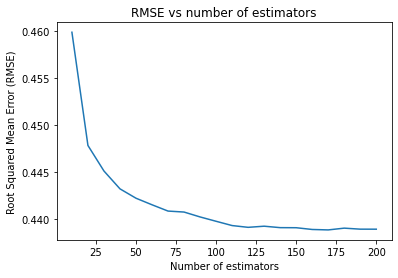

In [53]:
plt.plot(df_scores['n_estimators'], df_scores['RMSE'])
plt.xlabel('Number of estimators')
plt.ylabel('Root Squared Mean Error (RMSE)')
plt.title('RMSE vs number of estimators')
plt.show()

__Q3 answer__: `n_estimator = 120`

### Question 4. What's the best `max_depth`?

In [60]:
estimators = [*range(10, 201, 10)]
depths = [10, 15, 20, 25]
scores = []

for estimator in estimators:
    for max_depth in depths:
        rf = RandomForestRegressor(n_estimators=estimator, 
                                   max_depth=max_depth,
                                   random_state=1,
                                   n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        scores.append((max_depth, estimator, score))


In [61]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'RMSE'])
df_scores

,max_depth,n_estimators,RMSE
0,10,10,0.445596
1,15,10,0.449818
2,20,10,0.459764
3,25,10,0.460700
4,10,20,0.442033
...,...,...,...
75,25,190,0.438973
76,10,200,0.439679
77,15,200,0.436131
78,20,200,0.437646


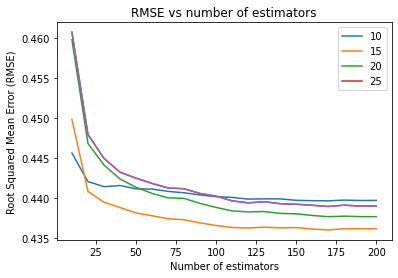

In [62]:
for depth in depths:
    df_subset = df_scores[df_scores['max_depth'] == depth]
    
    plt.plot(df_subset['n_estimators'], df_subset['RMSE'], label=depth)

plt.plot(df_subset['n_estimators'], df_subset['RMSE'])
plt.xlabel('Number of estimators')
plt.ylabel('Root Squared Mean Error (RMSE)')
plt.title('RMSE vs number of estimators')
plt.legend()
plt.show()

__Q4 answer__: the best `max_depth` value is 15

### Question 5. What's the most important feature?

Training the model:

In [65]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

Getting the feature importance:

In [69]:
importances = rf.feature_importances_
feature_names = df_train.columns

<AxesSubplot:>

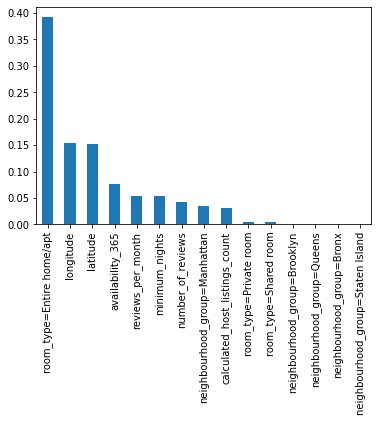

In [72]:
rf_importances = pd.Series(importances, index=dv.get_feature_names())
rf_importances.sort_values(ascending=False).plot(kind='bar')

__Q5 answer__: The most important feature is `room_type=Entire home/apt`

### Question 6. Which `eta` leads to the best RMSE score on validation dataset?

Instatiating a XGBoost model and getting DMatrices:

In [73]:
import xgboost as xgb

In [76]:
dv.fit_transform(train_dict)
feature_names = dv.get_feature_names()

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)

In [77]:
dv.transform(val_dict)
feature_names = dv.get_feature_names()

dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)

Creatting a watchlist:

In [78]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

Training the model:

In [ ]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train_rmse = float(train_line.split(':')[1])
        val_rmse = float(val_line.split(':')[1])

        results.append((it, train_rmse, val_rmse))

    df_results = pd.DataFrame(results, columns=['num_iteration', 'train_rmse', 'val_rmse'])
    
    return df_results

In [92]:
scores = {}

In [88]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 0,
}

xgboost = xgb.train(xgb_params, dtrain, evals=watchlist)

In [93]:
scores['eta=0.3'] = parse_xgb_output(output)

In [94]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 0,
}

xgboost = xgb.train(xgb_params, dtrain, evals=watchlist)

In [95]:
scores['eta=0.1'] = parse_xgb_output(output)

In [96]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 0,
}

xgboost = xgb.train(xgb_params, dtrain, evals=watchlist)

In [97]:
scores['eta=0.01'] = parse_xgb_output(output)

Plotting the results:

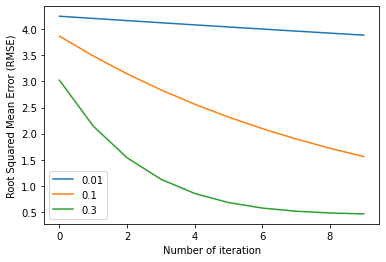

In [99]:
plt.plot(scores['eta=0.01'].num_iteration, scores['eta=0.01'].val_rmse, label='0.01')
plt.plot(scores['eta=0.1'].num_iteration, scores['eta=0.1'].val_rmse, label='0.1')
plt.plot(scores['eta=0.3'].num_iteration, scores['eta=0.3'].val_rmse, label='0.3')
plt.xlabel('Number of iteration')
plt.ylabel('Root Squared Mean Error (RMSE)')
plt.legend()

__Q6 answer__: `eta = 0.3` leads to the best RMSE